In [18]:
#reveal configuration
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'theme': 'white',
        'transition': 'none',
        'controls': 'false',
        'progress': 'true',
})

import tensorflow as tf
import numpy as np

%load_ext tikzmagic

The tikzmagic extension is already loaded. To reload it, use:
  %reload_ext tikzmagic


In [11]:
%%javascript
require(['base/js/utils'],
function(utils) {
   utils.load_extensions('calico-spell-check', 'calico-document-tools', 'calico-cell-tools');
});

<IPython.core.display.Javascript object>

In [12]:
%%html
<style>
.red { color: #E41A1C; }
.orange { color: #FF7F00 }
.yellow { color: #FFC020 }         
.green { color: #4DAF4A }                  
.blue { color: #377EB8; }
.purple { color: #984EA3 }       
</style>

# Applied Deep Learning for NLP

# Outline
- Use-case: Recognizing Textual Entailment
  - Conditional Encoding
  - Attention
- Bag of Tricks
  - Continuous Optimization
    - Momentum
    - Gradient Clipping
  - Regularization
    - Dropout
    - Early Stopping
  - Batching
  - Bucketing
  - Bi-directional RNNs
  - `dynamic_rnn`  


# Recognizing Textual Entailment (RTE)

- **A wedding party is taking pictures**
  - There is a funeral					: **<span class=red>Contradiction</span>**
  - They are outside					: **<span class=blue>Neutral</span>**
  - Someone got married				    : **<span class=green>Entailment</span>**

### State of the Art until 2015

[<span class=blue>Lai and Hockenmaier, 2014, Jimenez et al., 2014, Zhao et al., 2014, Beltagy et al., 2015</span> etc.]

- Engineered natural language processing pipelines
- Various external resources
- Specialized subcomponents
- Extensive manual creation of **features**:
  - Negation detection, word overlap, part-of-speech tags, dependency parses, alignment, unaligned matching, chunk alignment, synonym, hypernym, antonym, denotation graph

### Neural Networks for RTE

**Problem**:
- Tiny data sets
- Synthetic examples

**Stanford Natural Inference Corpus**:
- 500'000 sentence pairs
- Two orders of magnitude larger than existing RTE data set
- All examples generated by humans


### Independent Sentence Encoding

[<span class=blue>Bowman et al, 2015</span>]

Same LSTM encodes premise and hypothesis

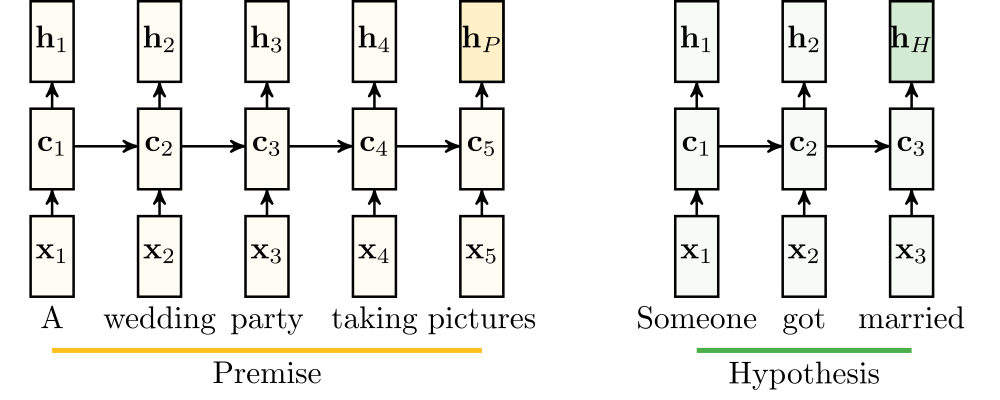

In [13]:
%%tikz -l arrows -sc 1.2 -s 1000,400 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

\foreach \i/\l in {1/1,2/2,3/3,4/4,5/5} {
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
}     
\path[draw, thick, fill=nice-yellow!25] (5-0.2,2) rectangle (5+0.2,2.75) {};  
\foreach \i/\l in {7/1,8/2,9/3} {
  \path[draw, thick, fill=nice-green!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
}
\path[draw, thick, fill=nice-green!25] (9-0.2,2) rectangle (9+0.2,2.75) {};        
\foreach \i/\l in {1/1,2/2,3/3,4/4,7/1,8/2} {
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}        
\node[] at (5,2.4) {$\mathbf{h}_P$};
\node[] at (9,2.4) {$\mathbf{h}_H$};        
\foreach \i in {1,2,3,4,7,8} {
  \draw[->, >=stealth', thick] (\i+0.2,1.4) -- (\i+1-0.2,1.4);
}

\foreach \i/\word in {1/A, 2/wedding, 3/party, 4/taking, 5/pictures, 6/, 7/Someone, 8/got, 9/married} {
  \node[anchor=north, text height=1.5ex, text depth=.25ex] at (\i,0) {\word};
}

\draw[ultra thick, nice-yellow] (1,-0.5) -- (5,-0.5);
\draw[ultra thick, nice-green] (7,-0.5) -- (9,-0.5);

\node[anchor=north] at (3,-0.5) {Premise};
\node[anchor=north] at (8,-0.5) {Hypothesis};  

### Independent Sentence Encoding

[<span class=blue>Bowman et al, 2015</span>]

Same LSTM encodes premise and hypothesis

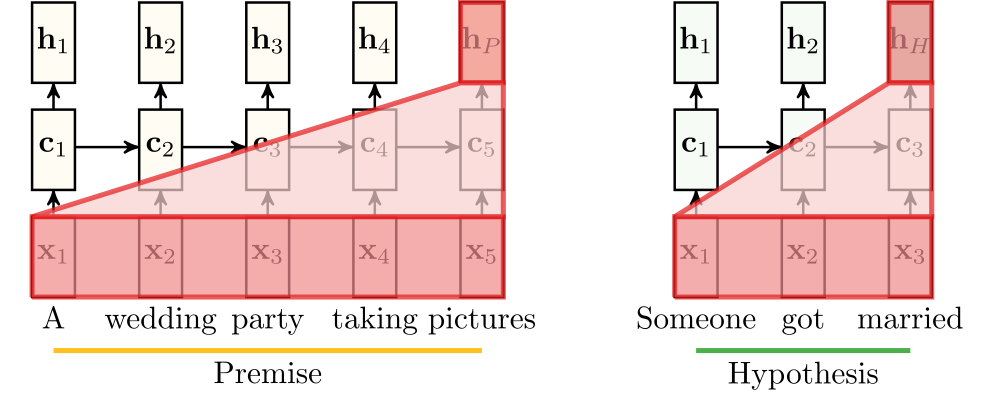

In [14]:
%%tikz -l arrows -sc 1.2 -s 1000,400 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

\foreach \i/\l in {1/1,2/2,3/3,4/4,5/5} {
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
}     
\path[draw, thick, fill=nice-yellow!25] (5-0.2,2) rectangle (5+0.2,2.75) {};  
\foreach \i/\l in {7/1,8/2,9/3} {
  \path[draw, thick, fill=nice-green!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
}
\path[draw, thick, fill=nice-green!25] (9-0.2,2) rectangle (9+0.2,2.75) {};        
\foreach \i/\l in {1/1,2/2,3/3,4/4,7/1,8/2} {
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}        
\node[] at (5,2.4) {$\mathbf{h}_P$};
\node[] at (9,2.4) {$\mathbf{h}_H$};        
\foreach \i in {1,2,3,4,7,8} {
  \draw[->, >=stealth', thick] (\i+0.2,1.4) -- (\i+1-0.2,1.4);
}

\foreach \i/\word in {1/A, 2/wedding, 3/party, 4/taking, 5/pictures, 6/, 7/Someone, 8/got, 9/married} {
  \node[anchor=north, text height=1.5ex, text depth=.25ex] at (\i,0) {\word};
}

\draw[ultra thick, nice-yellow] (1,-0.5) -- (5,-0.5);
\draw[ultra thick, nice-green] (7,-0.5) -- (9,-0.5);

\node[anchor=north] at (3,-0.5) {Premise};
\node[anchor=north] at (8,-0.5) {Hypothesis}; 

\foreach \s/\e in {0/5,6/9} {        
    \draw[ultra thick, color=nice-red, fill=nice-red!50!white, opacity=0.7] 
        (\s+0.8,0) -- (\e+0.2,0) -- (\e+0.2,0.75) -- (\s+0.8,0.75) -- (\s+0.8,0) 
        (\e-0.2,2) -- (\e+0.2,2) -- (\e+0.2,2.75) -- (\e-0.2,2.75) -- (\e-0.2,2);
    \draw[ultra thick, color=nice-red, fill=nice-red!20, opacity=0.7]         
        (\s+0.8,0.75) -- (\e+0.2,0.75) -- (\e+0.2,2) -- (\e-0.2,2) -- (\s+0.8,0.75);       
}                                    

> You can’t cram the meaning of a whole
%&!\$# sentence into a single \$&!#* vector!
>
> -- <cite>Raymond J. Mooney</cite>

### Independent Sentence Encoding

[<span class=blue>Bowman et al, 2015</span>]

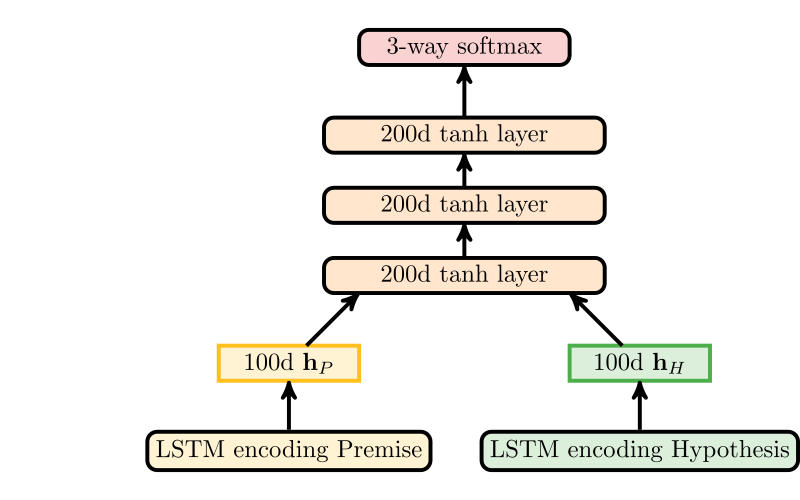

In [15]:
%%tikz -l arrows -s 800,500 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

%lstms
\node[anchor=center, draw, ultra thick, rounded corners, fill=nice-yellow!20] (P) at (0,0) {LSTM encoding Premise};
\node[anchor=center, draw, ultra thick, rounded corners, fill=nice-green!20] (H) at (5,0) {LSTM encoding Hypothesis};
%sentence vectors
\draw[ultra thick, color=nice-yellow, fill=nice-yellow!20] (-1,1) rectangle (1,1.5);
\draw[ultra thick, color=nice-green, fill=nice-green!20] (4,1) rectangle (6,1.5);
%tanh layers
\draw[ultra thick, fill=nice-orange!20, rounded corners] (0.5,2.25) rectangle (4.5,2.75);
\draw[ultra thick, fill=nice-orange!20, rounded corners] (0.5,3.25) rectangle (4.5,3.75);
\draw[ultra thick, fill=nice-orange!20, rounded corners] (0.5,4.25) rectangle (4.5,4.75);
%softmax
\draw[ultra thick, fill=nice-red!20, rounded corners] (1,5.5) rectangle (4,6);

%annotations
\node[] at (0,1.25) {100d $\mathbf{h}_P$};
\node[] at (5,1.25) {100d $\mathbf{h}_H$};
\node[] at (2.5,2.5) {200d tanh layer};
\node[] at (2.5,3.5) {200d tanh layer};
\node[] at (2.5,4.5) {200d tanh layer};
\node[] at (2.5,5.75) {3-way softmax};

%arrows
\draw[->, >=stealth', ultra thick] (P) -- (0,1);
\draw[->, >=stealth', ultra thick] (H) -- (5,1);
\draw[->, >=stealth', ultra thick] (0.25,1.5) -- (1,2.25);
\draw[->, >=stealth', ultra thick] (4.75,1.5) -- (4,2.25);
\draw[->, >=stealth', ultra thick] (2.5,2.75) -- (2.5,3.25);
\draw[->, >=stealth', ultra thick] (2.5,3.75) -- (2.5,4.25);
\draw[->, >=stealth', ultra thick] (2.5,4.75) -- (2.5,5.5);
      
%dummy node for centering
\node[] at (-4,0) {};

#### <span class="blue">TensorFlow</span>: Multi-layer Perceptron

In [128]:
with tf.Graph().as_default():
    def mlp(input_vector, layers=3, hidden_dim=200, output_dim=3):    
        # [input_size] => [input_size x 1] (column vector)
        tmp = tf.expand_dims(input_vector, 1)
        for i in range(layers+1):
            W = tf.get_variable(
                "W_"+str(i), [hidden_dim, hidden_dim])
            # tanh(Wx^T)
            tmp = tf.tanh(tf.matmul(W, tmp))
        W = tf.get_variable(
            "W_"+str(layers+1), [output_dim, hidden_dim])
        # [input_size x 1] => [input_size]
        return tf.squeeze(tf.matmul(W, tmp))

    premise = tf.placeholder(tf.float32, [None], "premise")
    hypothesis = tf.placeholder(tf.float32, [None], "hypothesis")
    output = tf.nn.softmax(mlp(tf.concat(0, [premise, hypothesis])))

    # in practice: outputs of an LSTM
    v1 = np.random.rand(100); v2 = np.random.rand(100)

    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        print(sess.run(output, {premise: v1, hypothesis: v2}))


[ 0.39673287  0.02954825  0.57371885]


| Model | k | θ<sub>W+M</sub> | θ<sub>M</sub> | Train | Dev | Test |
|-|-|-|-|-|-|-|
| LSTM [<span class=blue>Bowman et al.</span>] | 100 | \\(\approx\\)10M | 221k | 84.4 | - | 77.6|
| Classifier [<span class=blue>Bowman et al.</span>]| - | - | - | 99.7 | - | 78.2|

### Conditional Endcoding

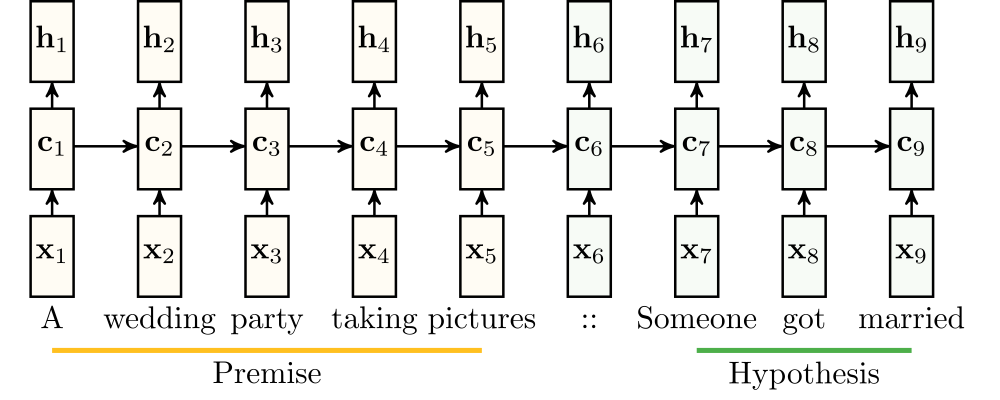

In [124]:
%%tikz -l arrows -sc 1.2 -s 1000,400 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

\foreach \i/\l in {1/1,2/2,3/3,4/4,5/5} {
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}
\foreach \i/\l in {6/6,7/7,8/8,9/9} {
  \path[draw, thick, fill=nice-green!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}
\foreach \i in {1,2,3,4,5,6,7,8} {
  \draw[->, >=stealth', thick] (\i+0.2,1.4) -- (\i+1-0.2,1.4);
}

\foreach \i/\word in {1/A, 2/wedding, 3/party, 4/taking, 5/pictures, 6/::, 7/Someone, 8/got, 9/married} {
  \node[anchor=north, text height=1.5ex, text depth=.25ex] at (\i,0) {\word};
}

\draw[ultra thick, nice-yellow] (1,-0.5) -- (5,-0.5);
\draw[ultra thick, nice-green] (7,-0.5) -- (9,-0.5);

\node[anchor=north] at (3,-0.5) {Premise};
\node[anchor=north] at (8,-0.5) {Hypothesis};

\begin{align}
\text{softmax}(\text{tanh}(\mathbf{W}\mathbf{h}_N))
\end{align}

### Conditional Endcoding

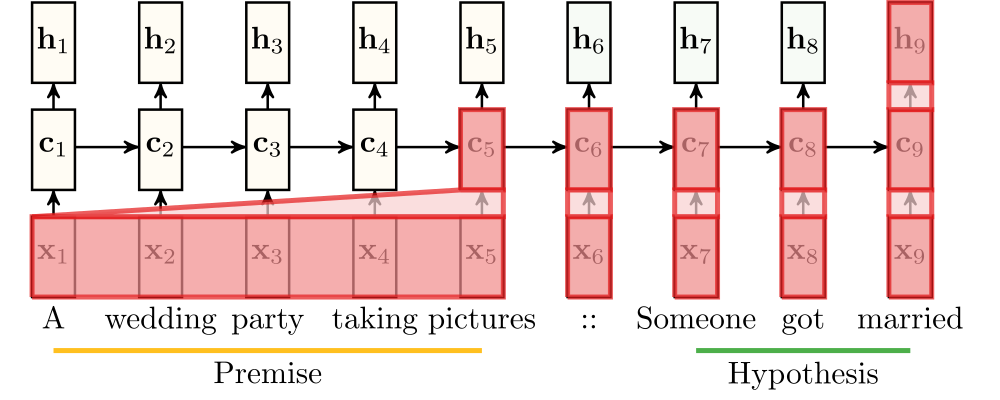

In [125]:
%%tikz -l arrows -sc 1.2 -s 1000,400 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

\foreach \i/\l in {1/1,2/2,3/3,4/4,5/5} {
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}
\foreach \i/\l in {6/6,7/7,8/8,9/9} {
  \path[draw, thick, fill=nice-green!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}
\foreach \i in {1,2,3,4,5,6,7,8} {
  \draw[->, >=stealth', thick] (\i+0.2,1.4) -- (\i+1-0.2,1.4);
}

\foreach \i/\word in {1/A, 2/wedding, 3/party, 4/taking, 5/pictures, 6/::, 7/Someone, 8/got, 9/married} {
  \node[anchor=north, text height=1.5ex, text depth=.25ex] at (\i,0) {\word};
}

\draw[ultra thick, nice-yellow] (1,-0.5) -- (5,-0.5);
\draw[ultra thick, nice-green] (7,-0.5) -- (9,-0.5);

\node[anchor=north] at (3,-0.5) {Premise};
\node[anchor=north] at (8,-0.5) {Hypothesis};
        
\foreach \s/\e in {0/5,5/6/,6/7,7/8} {        
    \draw[ultra thick, color=nice-red, fill=nice-red!50!white, opacity=0.7] 
        (\s+0.8,0) -- (\e+0.2,0) -- (\e+0.2,0.75) -- (\s+0.8,0.75) -- (\s+0.8,0) 
        (\e-0.2,1) -- (\e+0.2,1) -- (\e+0.2,1.75) -- (\e-0.2,1.75) -- (\e-0.2,1);
    \draw[ultra thick, color=nice-red, fill=nice-red!20, opacity=0.7]         
        (\s+0.8,0.75) -- (\e+0.2,0.75) -- (\e+0.2,1) -- (\e-0.2,1) -- (\s+0.8,0.75);       
} 
\foreach \s/\e in {8/9} {        
    \draw[ultra thick, color=nice-red, fill=nice-red!50!white, opacity=0.7] 
        (\s+0.8,0) -- (\e+0.2,0) -- (\e+0.2,0.75) -- (\s+0.8,0.75) -- (\s+0.8,0) 
        (\e-0.2,1) -- (\e+0.2,1) -- (\e+0.2,1.75) -- (\e-0.2,1.75) -- (\e-0.2,1)
        (\e-0.2,2) -- (\e+0.2,2) -- (\e+0.2,2.75) -- (\e-0.2,2.75) -- (\e-0.2,2);                                    
    \draw[ultra thick, color=nice-red, fill=nice-red!20, opacity=0.7]         
        (\s+0.8,0.75) -- (\e+0.2,0.75) -- (\e+0.2,1) -- (\e-0.2,1) -- (\s+0.8,0.75)  
        (\s+0.8,1.75) -- (\e+0.2,1.75) -- (\e+0.2,2) -- (\e-0.2,2) -- (\s+0.8,1.75);                                       
}          

\begin{align}
\text{softmax}(\text{tanh}(\mathbf{W}\mathbf{h}_N))
\end{align}

 | Model | k | θ<sub>W+M</sub> | θ<sub>M</sub> | Train | Dev | Test |
|-|-|-|-|-|-|-|
| LSTM [<span class=blue>Bowman et al.</span>] | 100 | \\(\approx\\)10M | 221k | 84.4 | - | 77.6|
| Classifier [<span class=blue>Bowman et al.</span>]| - | - | - | 99.7 | - | 78.2|
| Conditional Endcoding | 159 | 3.9M | 252k | 84.4 | 83.0 | 81.4|

### Attention [<span class=blue>Graves 2013</span>, <span class=blue>Bahdanau et al. 2015</span>]


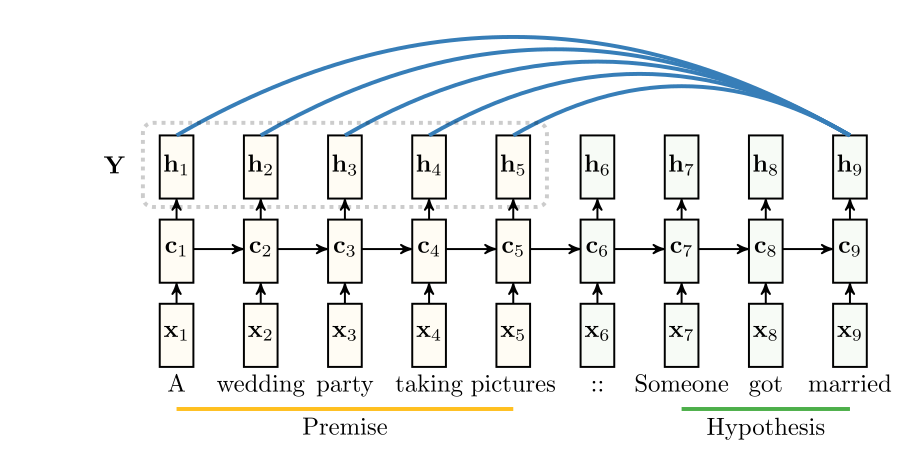

In [126]:
%%tikz -l arrows -sc 1.2 -s 900,450 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

\foreach \i/\l in {1/1,2/2,3/3,4/4,5/5} {
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}
\foreach \i/\l in {6/6,7/7,8/8,9/9} {
  \path[draw, thick, fill=nice-green!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}
\foreach \i in {1,2,3,4,5,6,7,8} {
  \draw[->, >=stealth', thick] (\i+0.2,1.4) -- (\i+1-0.2,1.4);
}

\foreach \i/\word in {1/A, 2/wedding, 3/party, 4/taking, 5/pictures, 6/::, 7/Someone, 8/got, 9/married} {
  \node[anchor=north, text height=1.5ex, text depth=.25ex] at (\i,0) {\word};
}
\foreach \i in {1,2,3,4,5} {
  \path[draw, ultra thick, color=nice-blue] (9,2.75) edge [bend right] (\i,2.75);
}

\draw[ultra thick, nice-yellow] (1,-0.5) -- (5,-0.5);
\draw[ultra thick, nice-green] (7,-0.5) -- (9,-0.5);

\node[anchor=north] at (3,-0.5) {Premise};
\node[anchor=north] at (8,-0.5) {Hypothesis};
        
%dummy node for centering
\node[] at (-1,0) {};         

\draw[ultra thick, rounded corners, opacity=0.2, dotted] (0.6,1.9) rectangle (5.4,2.9);  
\node[anchor=east] at (0.5,2.4) {$\mathbf{Y}$};        

<div class=small>
\begin{align}
  \mathbf{M} &= \tanh(\mathbf{W}^y\mathbf{Y}+ \mathbf{1}^T_L\mathbf{W}^h\mathbf{h}_N)&\mathbf{M}&\in\mathbb{R}^{k \times L}\\
  \alpha &= \text{softmax}(\mathbf{w}^T\mathbf{M})&\alpha&\in\mathbb{R}^L\\
  \mathbf{r} &= \mathbf{Y}\alpha^T&\mathbf{r}&\in\mathbb{R}^k
\end{align}
</div>

### Attention [<span class=blue>Graves 2013</span>, <span class=blue>Bahdanau et al. 2015</span>]


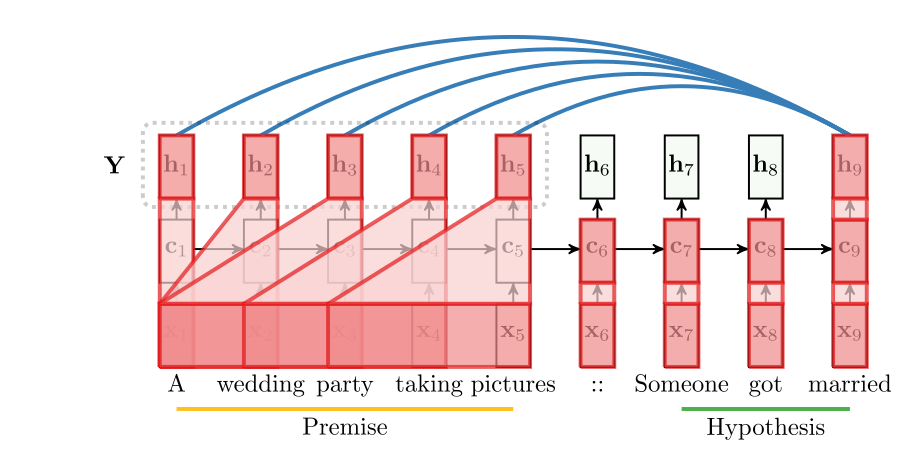

In [127]:
%%tikz -l arrows -sc 1.2 -s 900,450 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

\foreach \i/\l in {1/1,2/2,3/3,4/4,5/5} {
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}
\foreach \i/\l in {6/6,7/7,8/8,9/9} {
  \path[draw, thick, fill=nice-green!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}
\foreach \i in {1,2,3,4,5,6,7,8} {
  \draw[->, >=stealth', thick] (\i+0.2,1.4) -- (\i+1-0.2,1.4);
}

\foreach \i/\word in {1/A, 2/wedding, 3/party, 4/taking, 5/pictures, 6/::, 7/Someone, 8/got, 9/married} {
  \node[anchor=north, text height=1.5ex, text depth=.25ex] at (\i,0) {\word};
}
\foreach \i in {1,2,3,4,5} {
  \path[draw, ultra thick, color=nice-blue] (9,2.75) edge [bend right] (\i,2.75);
}

\draw[ultra thick, nice-yellow] (1,-0.5) -- (5,-0.5);
\draw[ultra thick, nice-green] (7,-0.5) -- (9,-0.5);

\node[anchor=north] at (3,-0.5) {Premise};
\node[anchor=north] at (8,-0.5) {Hypothesis};
        
%dummy node for centering
\node[] at (-1,0) {}; 

\draw[ultra thick, rounded corners, opacity=0.2, dotted] (0.6,1.9) rectangle (5.4,2.9);  
\node[anchor=east] at (0.5,2.4) {$\mathbf{Y}$};         
        
\foreach \s/\e in {0/1,0/2,0/3,1/4,2/5} {        
    \draw[ultra thick, color=nice-red, fill=nice-red!50!white, opacity=0.7] 
        (\s+0.8,0) -- (\e+0.2,0) -- (\e+0.2,0.75) -- (\s+0.8,0.75) -- (\s+0.8,0) 
        (\e-0.2,2) -- (\e+0.2,2) -- (\e+0.2,2.75) -- (\e-0.2,2.75) -- (\e-0.2,2);
    \draw[ultra thick, color=nice-red, fill=nice-red!20, opacity=0.7]         
        (\s+0.8,0.75) -- (\e+0.2,0.75) -- (\e+0.2,2) -- (\e-0.2,2) -- (\s+0.8,0.75);       
}                                            
        
\foreach \s/\e in {5/6/,6/7,7/8} {        
    \draw[ultra thick, color=nice-red, fill=nice-red!50!white, opacity=0.7] 
        (\s+0.8,0) -- (\e+0.2,0) -- (\e+0.2,0.75) -- (\s+0.8,0.75) -- (\s+0.8,0) 
        (\e-0.2,1) -- (\e+0.2,1) -- (\e+0.2,1.75) -- (\e-0.2,1.75) -- (\e-0.2,1);
    \draw[ultra thick, color=nice-red, fill=nice-red!20, opacity=0.7]         
        (\s+0.8,0.75) -- (\e+0.2,0.75) -- (\e+0.2,1) -- (\e-0.2,1) -- (\s+0.8,0.75);       
} 
\foreach \s/\e in {8/9} {        
    \draw[ultra thick, color=nice-red, fill=nice-red!50!white, opacity=0.7] 
        (\s+0.8,0) -- (\e+0.2,0) -- (\e+0.2,0.75) -- (\s+0.8,0.75) -- (\s+0.8,0) 
        (\e-0.2,1) -- (\e+0.2,1) -- (\e+0.2,1.75) -- (\e-0.2,1.75) -- (\e-0.2,1)
        (\e-0.2,2) -- (\e+0.2,2) -- (\e+0.2,2.75) -- (\e-0.2,2.75) -- (\e-0.2,2);                                    
    \draw[ultra thick, color=nice-red, fill=nice-red!20, opacity=0.7]         
        (\s+0.8,0.75) -- (\e+0.2,0.75) -- (\e+0.2,1) -- (\e-0.2,1) -- (\s+0.8,0.75)  
        (\s+0.8,1.75) -- (\e+0.2,1.75) -- (\e+0.2,2) -- (\e-0.2,2) -- (\s+0.8,1.75);                                       
}                 

<div class=small>
\begin{align}
  \mathbf{M} &= \tanh(\mathbf{W}^y\mathbf{Y}+ \mathbf{1}^T_L\mathbf{W}^h\mathbf{h}_N)&\mathbf{M}&\in\mathbb{R}^{k \times L}\\
  \alpha &= \text{softmax}(\mathbf{w}^T\mathbf{M})&\alpha&\in\mathbb{R}^L\\
  \mathbf{r} &= \mathbf{Y}\alpha^T&\mathbf{r}&\in\mathbb{R}^k
\end{align}
</div>

<img  src="./dl-applications-figures/camel.png"/>

#### Contextual Understanding

<img  src="./dl-applications-figures/pink.png"/>

| Model | k | θ<sub>W+M</sub> | θ<sub>M</sub> | Train | Dev | Test |
|-|-|-|-|-|-|-|
| LSTM [<span class=blue>Bowman et al.</span>] | 100 | \\(\approx\\)10M | 221k | 84.4 | - | 77.6|
| Classifier [<span class=blue>Bowman et al.</span>]| - | - | - | 99.7 | - | 78.2|
| Conditional Encoding | 159 | 3.9M | 252k | 84.4 | 83.0 | 81.4|
| Attention | 100 | 3.9M | 242k | 85.4 | 83.2 | 82.3 |

#### Fuzzy Attention

<img  src="./dl-applications-figures/mimes.png"/>

### Word-by-word Attention [<span class=blue>Bahdanau et al. 2015</span>, <span class=blue>Hermann et al. 2015</span>, <span class=blue>Rush et al. 2015</span>]

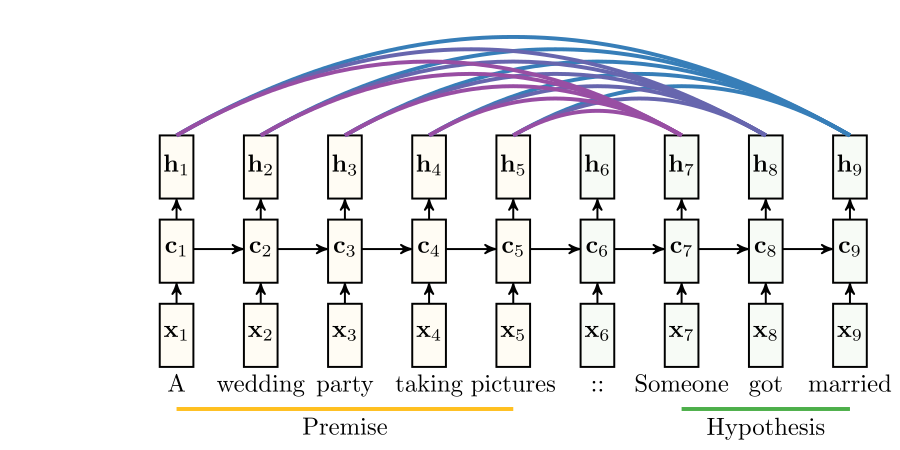

In [31]:
%%tikz -l arrows -sc 1.2 -s 900,450 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

\foreach \i/\l in {1/1,2/2,3/3,4/4,5/5} {
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}
\foreach \i/\l in {6/6,7/7,8/8,9/9} {
  \path[draw, thick, fill=nice-green!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}
\foreach \i in {1,2,3,4,5,6,7,8} {
  \draw[->, >=stealth', thick] (\i+0.2,1.4) -- (\i+1-0.2,1.4);
}

\foreach \i/\word in {1/A, 2/wedding, 3/party, 4/taking, 5/pictures, 6/::, 7/Someone, 8/got, 9/married} {
  \node[anchor=north, text height=1.5ex, text depth=.25ex] at (\i,0) {\word};
}
\foreach \i in {1,2,3,4,5} {
  \path[draw, ultra thick, color=nice-blue] (9,2.75) edge [bend right] (\i,2.75);
}

\foreach \i in {1,2,3,4,5} {
  \path[draw, ultra thick, color=nice-blue!50!nice-purple] (8,2.75) edge [bend right] (\i,2.75);
}

\foreach \i in {1,2,3,4,5} {
  \path[draw, ultra thick, color=nice-purple] (7,2.75) edge [bend right] (\i,2.75);
}

\draw[ultra thick, nice-yellow] (1,-0.5) -- (5,-0.5);
\draw[ultra thick, nice-green] (7,-0.5) -- (9,-0.5);

\node[anchor=north] at (3,-0.5) {Premise};
\node[anchor=north] at (8,-0.5) {Hypothesis};
        
%dummy node for centering
\node[] at (-1,0) {};

<div class=small>
\begin{align}
  \mathbf{M}_t &= \tanh(\mathbf{W}^y\mathbf{Y}+\mathbf{1}^T_L(\mathbf{W}^h\mathbf{h}_t+\mathbf{W}^r\mathbf{r}_{t-1})) & \mathbf{M}_t &\in\mathbb{R}^{k\times L}\\
  \alpha_t &= \text{softmax}(\mathbf{w}^T\mathbf{M}_t)&\alpha_t&\in\mathbb{R}^L\\
  \mathbf{r}_t &= \mathbf{Y}\alpha^T_t + \tanh(\mathbf{W}^t\mathbf{r}_{t-1})&\mathbf{r}_t&\in\mathbb{R}^k
\end{align}
</div>

### Word-by-word Attention [<span class=blue>Bahdanau et al. 2015</span>, <span class=blue>Hermann et al. 2015</span>, <span class=blue>Rush et al. 2015</span>]

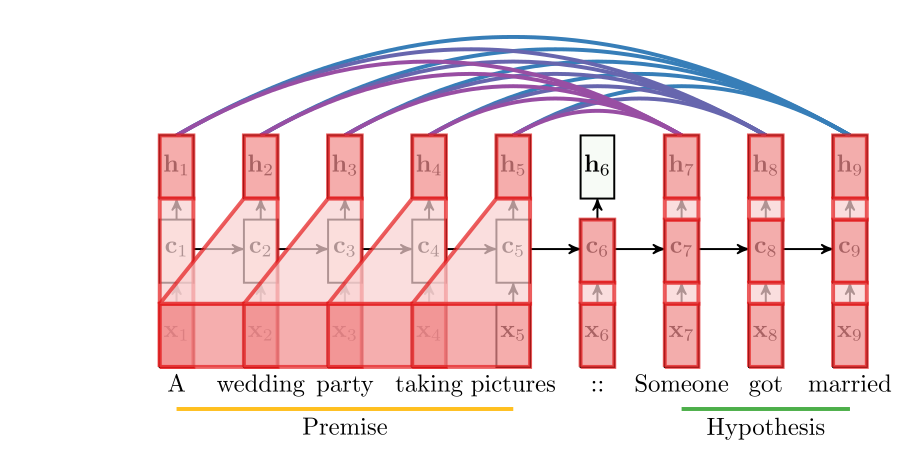

In [30]:
%%tikz -l arrows -sc 1.2 -s 900,450 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

\foreach \i/\l in {1/1,2/2,3/3,4/4,5/5} {
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}
\foreach \i/\l in {6/6,7/7,8/8,9/9} {
  \path[draw, thick, fill=nice-green!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}
\foreach \i in {1,2,3,4,5,6,7,8} {
  \draw[->, >=stealth', thick] (\i+0.2,1.4) -- (\i+1-0.2,1.4);
}

\foreach \i/\word in {1/A, 2/wedding, 3/party, 4/taking, 5/pictures, 6/::, 7/Someone, 8/got, 9/married} {
  \node[anchor=north, text height=1.5ex, text depth=.25ex] at (\i,0) {\word};
}
\foreach \i in {1,2,3,4,5} {
  \path[draw, ultra thick, color=nice-blue] (9,2.75) edge [bend right] (\i,2.75);
}

\foreach \i in {1,2,3,4,5} {
  \path[draw, ultra thick, color=nice-blue!50!nice-purple] (8,2.75) edge [bend right] (\i,2.75);
}

\foreach \i in {1,2,3,4,5} {
  \path[draw, ultra thick, color=nice-purple] (7,2.75) edge [bend right] (\i,2.75);
}

\draw[ultra thick, nice-yellow] (1,-0.5) -- (5,-0.5);
\draw[ultra thick, nice-green] (7,-0.5) -- (9,-0.5);

\node[anchor=north] at (3,-0.5) {Premise};
\node[anchor=north] at (8,-0.5) {Hypothesis};
        
%dummy node for centering
\node[] at (-1,0) {};
        
\foreach \s/\e in {0/1,0/2,1/3,2/4,3/5} {        
    \draw[ultra thick, color=nice-red, fill=nice-red!50!white, opacity=0.7] 
        (\s+0.8,0) -- (\e+0.2,0) -- (\e+0.2,0.75) -- (\s+0.8,0.75) -- (\s+0.8,0) 
        (\e-0.2,2) -- (\e+0.2,2) -- (\e+0.2,2.75) -- (\e-0.2,2.75) -- (\e-0.2,2);
    \draw[ultra thick, color=nice-red, fill=nice-red!20, opacity=0.7]         
        (\s+0.8,0.75) -- (\e+0.2,0.75) -- (\e+0.2,2) -- (\e-0.2,2) -- (\s+0.8,0.75);       
}                                            
\foreach \s/\e in {6/7,7/8,8/9} {        
    \draw[ultra thick, color=nice-red, fill=nice-red!50!white, opacity=0.7] 
        (\s+0.8,0) -- (\e+0.2,0) -- (\e+0.2,0.75) -- (\s+0.8,0.75) -- (\s+0.8,0) 
        (\e-0.2,1) -- (\e+0.2,1) -- (\e+0.2,1.75) -- (\e-0.2,1.75) -- (\e-0.2,1)
        (\e-0.2,2) -- (\e+0.2,2) -- (\e+0.2,2.75) -- (\e-0.2,2.75) -- (\e-0.2,2);                                    
    \draw[ultra thick, color=nice-red, fill=nice-red!20, opacity=0.7]         
        (\s+0.8,0.75) -- (\e+0.2,0.75) -- (\e+0.2,1) -- (\e-0.2,1) -- (\s+0.8,0.75)  
        (\s+0.8,1.75) -- (\e+0.2,1.75) -- (\e+0.2,2) -- (\e-0.2,2) -- (\s+0.8,1.75);                                       
}          
\foreach \s/\e in {5/6} {        
    \draw[ultra thick, color=nice-red, fill=nice-red!50!white, opacity=0.7] 
        (\s+0.8,0) -- (\e+0.2,0) -- (\e+0.2,0.75) -- (\s+0.8,0.75) -- (\s+0.8,0) 
        (\e-0.2,1) -- (\e+0.2,1) -- (\e+0.2,1.75) -- (\e-0.2,1.75) -- (\e-0.2,1);
    \draw[ultra thick, color=nice-red, fill=nice-red!20, opacity=0.7]         
        (\s+0.8,0.75) -- (\e+0.2,0.75) -- (\e+0.2,1) -- (\e-0.2,1) -- (\s+0.8,0.75);  
}         

<div class=small>
\begin{align}
  \mathbf{M}_t &= \tanh(\mathbf{W}^y\mathbf{Y}+\mathbf{1}^T_L(\mathbf{W}^h\mathbf{h}_t+\mathbf{W}^r\mathbf{r}_{t-1})) & \mathbf{M}_t &\in\mathbb{R}^{k\times L}\\
  \alpha_t &= \text{softmax}(\mathbf{w}^T\mathbf{M}_t)&\alpha_t&\in\mathbb{R}^L\\
  \mathbf{r}_t &= \mathbf{Y}\alpha^T_t + \tanh(\mathbf{W}^t\mathbf{r}_{t-1})&\mathbf{r}_t&\in\mathbb{R}^k
\end{align}
</div>

#### Reordering

<img src="./dl-applications-figures/reordering.png" width=60%/>

#### Garbage Can = Trashcan

<img  src="./dl-applications-figures/trashcan.png" width=90%/>

#### Kids =  Girl + Boy

<img  src="./dl-applications-figures/kids.png" width=80%/>

## Snow is outside

<img  src="./dl-applications-figures/snow.png"/>

## Results

| Model | k | θ<sub>W+M</sub> | θ<sub>M</sub> | Train | Dev | Test |
|-|-|-|-|-|-|-|
| LSTM [<span class=blue>Bowman et al.</span>] | 100 | \\(\approx\\)10M | 221k | 84.4 | - | 77.6|
| Classifier [<span class=blue>Bowman et al.</span>]| - | - | - | 99.7 | - | 78.2|
| Conditional Encoding | 159 | 3.9M | 252k | 84.4 | 83.0 | 81.4|
| Attention | 100 | 3.9M | 242k | 85.4 | 83.2 | 82.3 |
| Word-by-word Attention | 100 | 3.9M | 252k | 85.3 | **83.7** | **83.5** |

# Bag of Tricks

## Continuous Optimization

### Momentum

### Gradient Clipping

## Regularization

### Dropout

### Early Stopping

## Batching

## Bucketing

## Bi-directional RNNs

## `dynamic_rnn`

# Background Material

- [A Primer on Neural Network Models for Natural Language Processing](http://www.jair.org/media/4992/live-4992-9623-jair.pdf)
- [Stanford Course: Deep Learning for Natural Language Processing](http://cs224d.stanford.edu/syllabus.html)